In [79]:
def avg(arr):
    return sum(arr) / len(arr) if len(arr) > 0 else 0

In [80]:
import re
import os
import pprint

def analyze_text_files(*file_paths):
    results = {}
    patterns = [
        (r'fillrandom\s+:\s+(\d+\.\d+)\s+micros/op;\s+(\d+\.\d+)\s+MB/s', ('fillrandom', float, float)),
        (r'overwrite\s+:\s+(\d+\.\d+)\s+micros/op;\s+(\d+\.\d+)\s+MB/s', ('overwrite', float, float)),
        (r'_get_avg_size_\s+:\s+\d+\.\d+\s+micros/op;\s+average filter size:\s+(\d+\.\d+)\s+bytes', ('avgsize', float)),
        (r'readrandom\s+:\s+(\d+\.\d+)\s+micros/op;\s+\(\d+\sof\s\d+\sfound\)', ('readrandom', float)),
        (r'readmissing\s+:\s+(\d+\.\d+)\s+micros/op;', ('readmissing', float))
    ]

    for file_path in file_paths:
        file_name = file_path.split('/')[-1].rstrip('.txt')
        results[file_name] = []

        # TODO uncomment when all files are computed
        if (os.path.exists(file_path)):
            with open(file_path, 'r') as file:
                for line in file:
                    for pattern, template in patterns:
                        match = re.match(pattern, line)
                        if match:
                            values = [float (match.group(i+1)) for i in range(len(template)-1)]
                            results[file_name].append(tuple([template[0]] + values))
                            break

    return results

blooms = [f'bloom_{i}' for i in range(1, 17)]

files = ['ribbon_8',
         'xor_8', 'xor_16',
         'binary_fuse_8', 'binary_fuse_16',
         'cuckoo_8', 'cuckoo_12', 'cuckoo_16',
         'vacuum_8', 'vacuum_12', 'vacuum_16',
         'vacuum_packed_8',
         'none_0'
         ] + blooms
relative = '/Users/mgajek/CLionProjects/leveldb/build/'

file_paths = [f"{relative}{file}.txt" for file in files]

results = analyze_text_files(*file_paths)
pprint.pprint(results)


{'binary_fuse_16': [('fillrandom', 6.592, 4.6),
                    ('overwrite', 8.326, 3.7),
                    ('overwrite', 8.376, 3.6),
                    ('avgsize', 264139.736318),
                    ('readrandom', 4.257),
                    ('readrandom', 3.967),
                    ('readrandom', 3.949),
                    ('readmissing', 3.939)],
 'binary_fuse_8': [('fillrandom', 6.517, 4.7),
                   ('overwrite', 7.981, 3.8),
                   ('overwrite', 8.076, 3.8),
                   ('avgsize', 143406.681592),
                   ('readrandom', 5.007),
                   ('readrandom', 4.95),
                   ('readrandom', 4.972),
                   ('readmissing', 4.929)],
 'bloom_1': [('fillrandom', 6.758, 4.5),
             ('overwrite', 8.157, 3.7),
             ('overwrite', 8.552, 3.6),
             ('avgsize', 12283.325871),
             ('readrandom', 5.312),
             ('readrandom', 5.132),
             ('readrandom', 4.881),
            

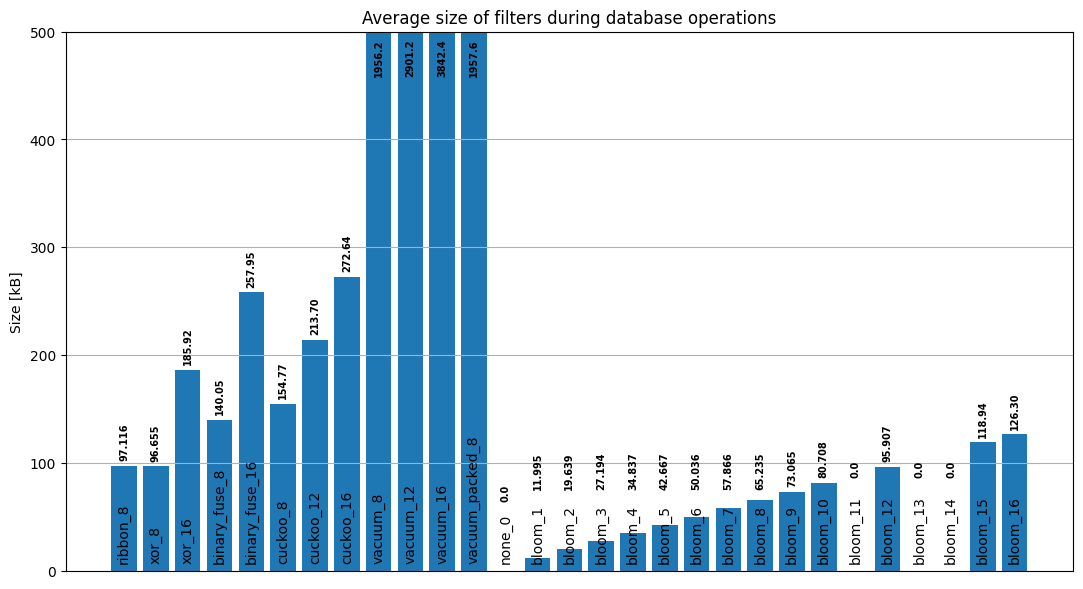

In [81]:
import matplotlib.pyplot as plt

keys = [key for key in results.keys()]
sizes = [sum([x[1] for x in results[key] if x[0] == 'avgsize'])/ 1024 for key in keys]

plt.figure(figsize=(13, 7))

for i, label in enumerate(keys):
    plt.text(i, 10, label, ha='center', rotation='vertical')

for i, s in enumerate(sizes):
    plt.text(i, min(max(-0.8 if s < 0.1 else s + 7, len(keys[i]) * 11), 500 - 40),
             f"{s:.1f}" if s < 0.1 else f"{s:.{5-len(str(int(s)))}f}",
             ha='center',
             fontweight='bold',
             fontsize='7',
             rotation='vertical',)
            #  bbox={'facecolor': 'white', 'alpha': 0.7, 'edgecolor': 'none', 'pad': 5})

# for i, label in enumerate(keys):
#     plt.text(i, min([sizes[i] + 10, 380]), label, ha='center', rotation='vertical')

plt.xticks([])
plt.grid()
plt.bar(keys, sizes)
plt.ylabel('Size [kB]')
plt.title('Average size of filters during database operations')
plt.ylim(0, 500)
plt.show()


In [82]:
def aggregate_results(arr):
    result = dict()

    write_values = [(x[1], x[2]) for x in arr if x[0]=='fillrandom' or x[0]=='overwrite']

    result['write'] = avg([w[0] for w in write_values]), avg([w[1] for w in write_values])

    result['readrandom'] = avg([x[1] for x in arr if x[0]=='readrandom'])
    result['readmissing'] = sum([x[1] for x in arr if x[0]=='readmissing'])

    return result

aggregated = {key: aggregate_results(values) for (key, values) in results.items()}
pprint.pprint(aggregated)

{'binary_fuse_16': {'readmissing': 3.939,
                    'readrandom': 4.057666666666667,
                    'write': (7.764666666666666, 3.966666666666667)},
 'binary_fuse_8': {'readmissing': 4.929,
                   'readrandom': 4.976333333333334,
                   'write': (7.5246666666666675, 4.1000000000000005)},
 'bloom_1': {'readmissing': 5.914,
             'readrandom': 5.108333333333333,
             'write': (7.822333333333333, 3.933333333333333)},
 'bloom_10': {'readmissing': 3.269,
              'readrandom': 3.5703333333333336,
              'write': (7.667999999999999, 4.066666666666666)},
 'bloom_11': {'readmissing': 0, 'readrandom': 0, 'write': (0, 0)},
 'bloom_12': {'readmissing': 4.306,
              'readrandom': 4.674,
              'write': (7.5423333333333344, 4.1000000000000005)},
 'bloom_13': {'readmissing': 0, 'readrandom': 0, 'write': (0, 0)},
 'bloom_14': {'readmissing': 0, 'readrandom': 0, 'write': (0, 0)},
 'bloom_15': {'readmissing': 4.965,
     

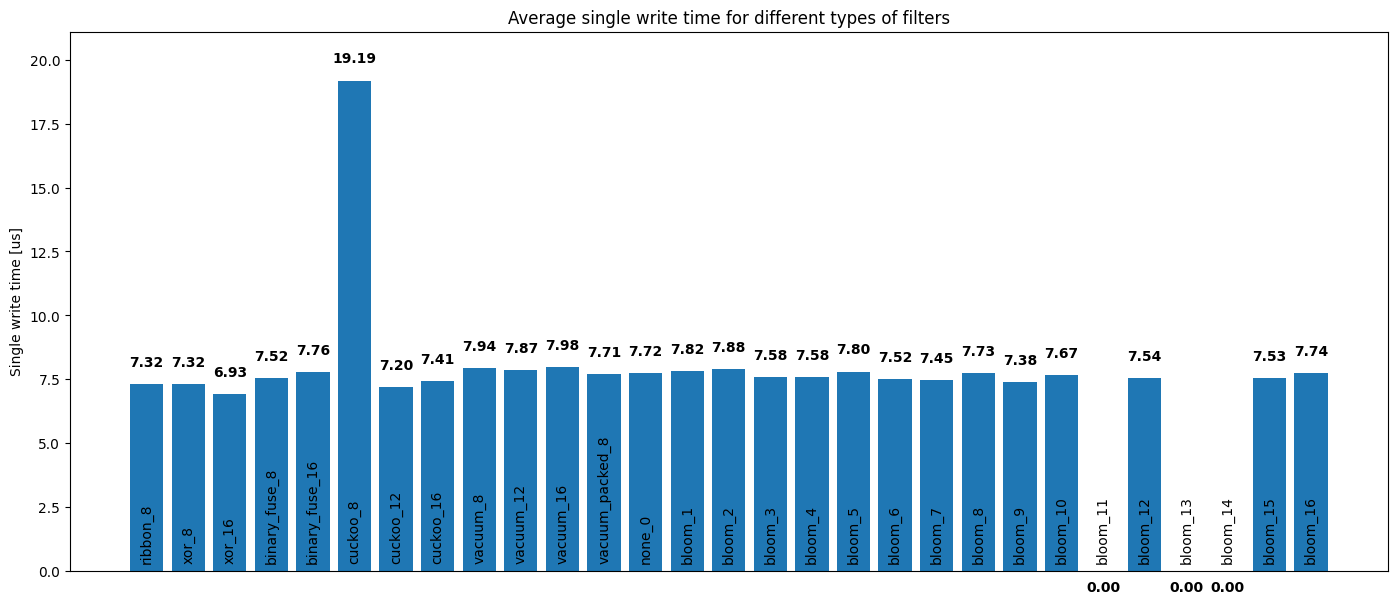

In [83]:
plt.figure(figsize=(17, 7))

write_times = [value_dict['write'][0] for value_dict in aggregated.values()]

plt.bar(aggregated.keys(), write_times)

for i, label in enumerate(aggregated.keys()):
    plt.text(i, 0.4, label, ha='center', rotation='vertical')

for i, wt in enumerate(write_times):
    plt.text(i, min(-0.8 if wt < 0.1 else wt + 0.7, max(write_times) * 1.1 - 1),
             f"{wt:.2f}",
             ha='center',
             fontweight='bold',
             bbox={'facecolor': 'white', 'alpha': 0.7, 'edgecolor': 'none', 'pad': 5})

# for i, label in enumerate(aggregated.keys()):
#     plt.text(i, 0.5, label, ha='center', rotation='vertical')

plt.xticks([])
plt.ylabel('Single write time [us]')
plt.title('Average single write time for different types of filters')
plt.ylim(0, max(write_times) * 1.1)  # Adjust the y-axis limit to 10% above the maximum value
plt.show()

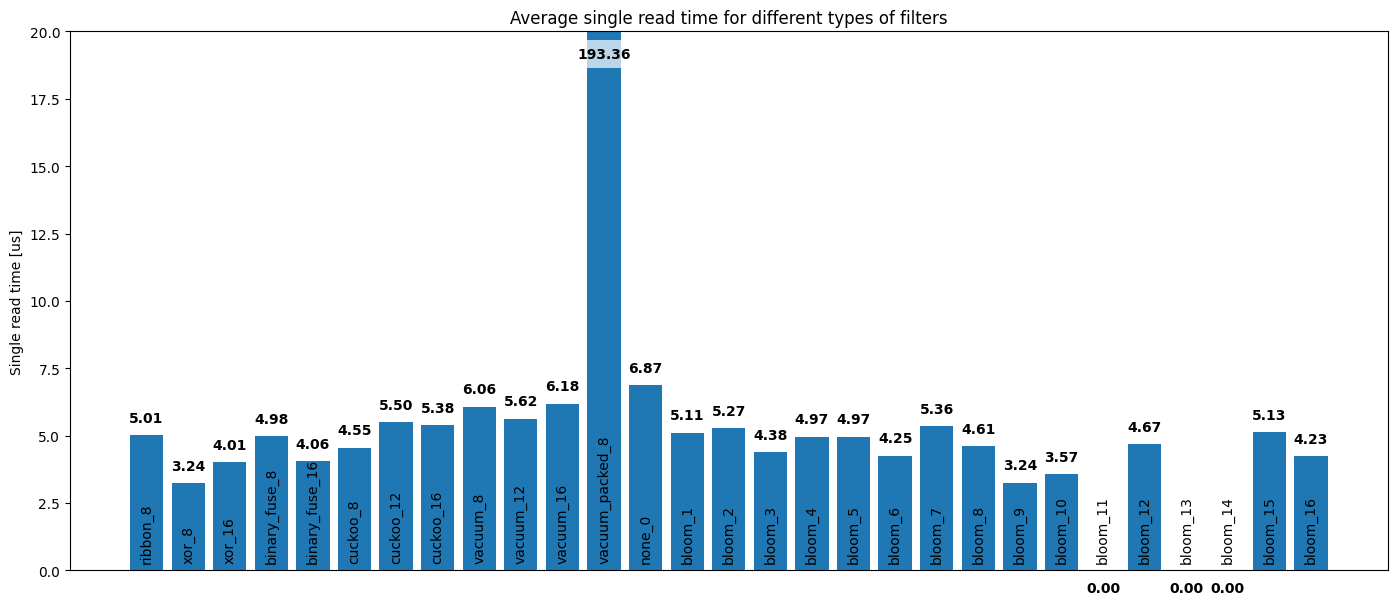

In [84]:
plt.figure(figsize=(17, 7))

read_rnd_times = [value_dict['readrandom'] for value_dict in aggregated.values()]

for i, label in enumerate(aggregated.keys()):
    plt.text(i, 0.4, label, ha='center', rotation='vertical')

for i, read_time in enumerate(read_rnd_times):
    plt.text(i, min(-0.8 if read_time < 0.1 else read_time + 0.5, 19),
             f"{read_time:.2f}",
             ha='center',
             fontweight='bold',
             bbox={'facecolor': 'white', 'alpha': 0.7, 'edgecolor': 'none', 'pad': 5})


plt.xticks([])

plt.bar(aggregated.keys(), read_rnd_times)
plt.ylabel('Single read time [us]')
plt.title('Average single read time for different types of filters')
plt.ylim(0, 20)  # Adjust the y-axis limit to 10% above the maximum value
plt.show()

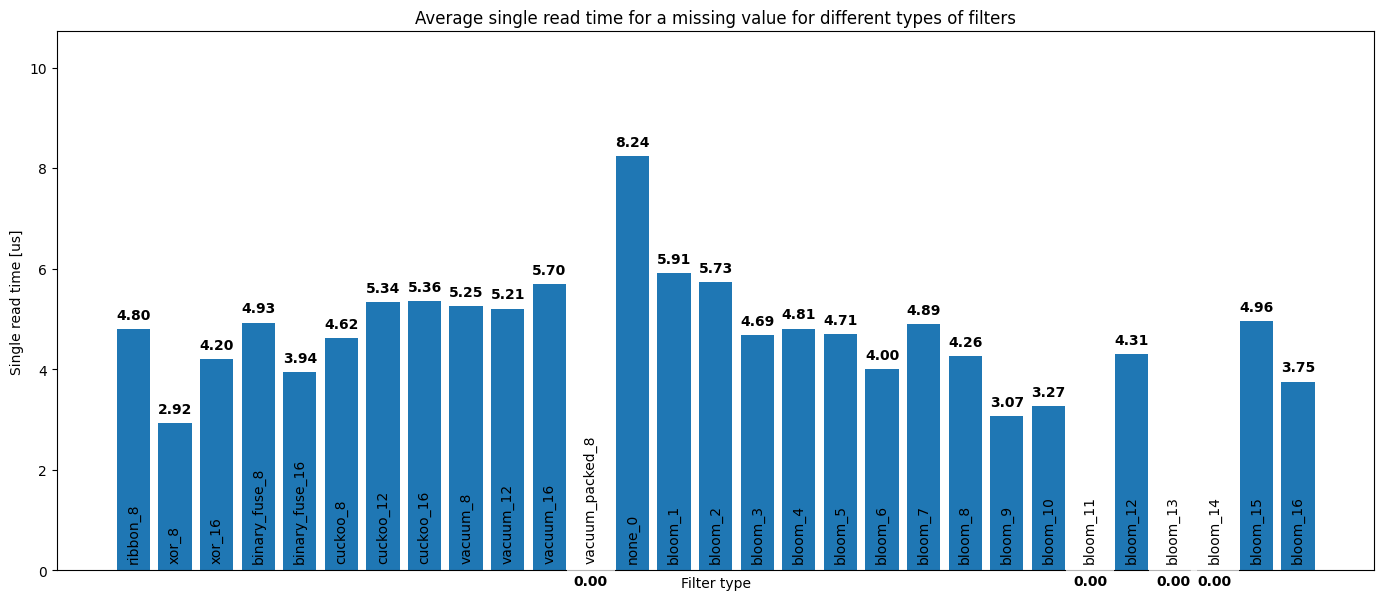

In [85]:
plt.figure(figsize=(17, 7))

read_miss_times = [value_dict['readmissing'] for value_dict in aggregated.values()]

for i, label in enumerate(aggregated.keys()):
    plt.text(i, 0.2, label, ha='center', rotation='vertical')

for i, read_time in enumerate(read_miss_times):
    plt.text(i, min(-0.3 if read_time < 0.1 else read_time + 0.2, 19),
             f"{read_time:.2f}",
             ha='center',
             fontweight='bold',
             bbox={'facecolor': 'white', 'alpha': 0.7, 'edgecolor': 'none', 'pad': 5})

plt.xticks([])

plt.bar(aggregated.keys(), read_miss_times)
plt.xlabel('Filter type')
plt.ylabel('Single read time [us]')
plt.title('Average single read time for a missing value for different types of filters')
plt.ylim(0, max(read_miss_times) * 1.3)  # Adjust the y-axis limit to 10% above the maximum value
plt.show()

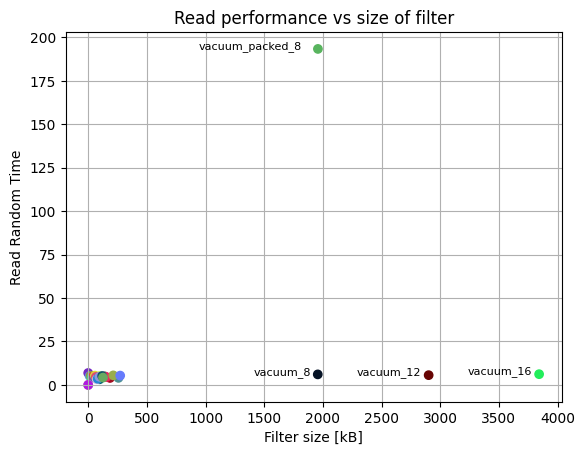

In [86]:
import matplotlib.pyplot as plt
import numpy as np

colors = np.random.rand(len(keys), 3)

plt.scatter(sizes, read_rnd_times, c=colors)
plt.grid()

size_limit = 310
read_limit = 8

plt.xlabel('Filter size [kB]')
# TODO Change name
plt.ylabel('Read Random Time')
plt.title('Read performance vs size of filter')

for i, key in enumerate(keys):
    if (sizes[i] >= size_limit or read_rnd_times[i] >= read_limit):
        plt.text(sizes[i] - len(key) * 68,
                 read_rnd_times[i],
                 key if key[:5] != 'bloom' else f'b_{key[6:]}',
                 fontsize=8)

plt.show()


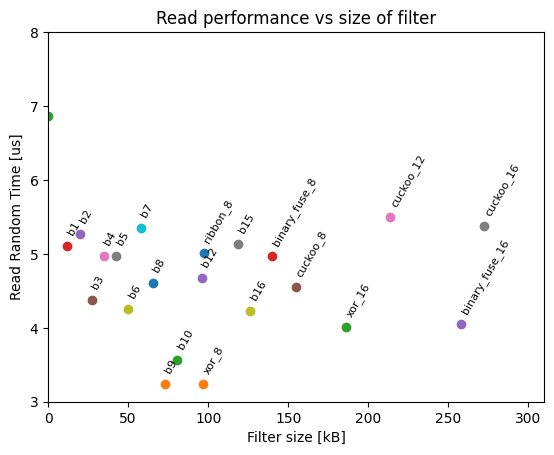

In [87]:
import matplotlib.pyplot as plt
import numpy as np

colors = np.random.rand(len(keys), 3)

for size, time, key in zip(sizes, read_rnd_times, keys):
    plt.scatter(size, time, label=key)
# plt.scatter(sizes, read_rnd_times, c=colors)
# plt.grid()

size_limit = 310
read_limit = 8

plt.xlabel('Filter size [kB]')
# TODO Change name
plt.ylabel('Read Random Time [us]')
plt.title('Read performance vs size of filter')

for i, key in enumerate(keys):
    if (sizes[i] < size_limit and read_rnd_times[i] < read_limit and sizes[i] > 0.01):
        plt.text(sizes[i] - 1,
                 read_rnd_times[i] + 0.15,
                 key if key[:5] != 'bloom' else f'b{key[6:]}',
                 rotation=60,
                 fontsize=8)

plt.xlim(0, size_limit)  # Adjust the limits for the x-axis
plt.ylim(3, read_limit)

plt.show()
